In [3]:
!pip install tensorflow datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [5]:
dataset,info=tfds.load('horses_or_humans',with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteKAMSTE/horses_or_humans-train.tfrecord*..…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteKAMSTE/horses_or_humans-test.tfrecord*...…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [6]:
class_names=info.features['label'].names
class_names

['horses', 'humans']

In [7]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path=PosixGPath('/tmp/tmpuv76i9_ntfds'),
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [8]:
for i, example in enumerate(dataset['train']):
  image,label = example[0], example[1]
  save_dir = './horse-or-human/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filename = '{}_{}.jpg'.format(class_names[label], i)
  filepath = save_dir + "/" + filename

  tf.keras.preprocessing.image.save_img(filepath, image)
  # break

In [9]:
for i, example in enumerate(dataset['test']):
  image,label = example[0], example[1]
  save_dir = './horse-or-human/test/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filename = '{}_{}.jpg'.format(class_names[label], i)
  filepath = save_dir + "/" + filename

  tf.keras.preprocessing.image.save_img(filepath, image)
  # break

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
train_dir = '/content/horse-or-human/train'
image_size = (300, 300)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

test_dir = '/content/horse-or-human/test'
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

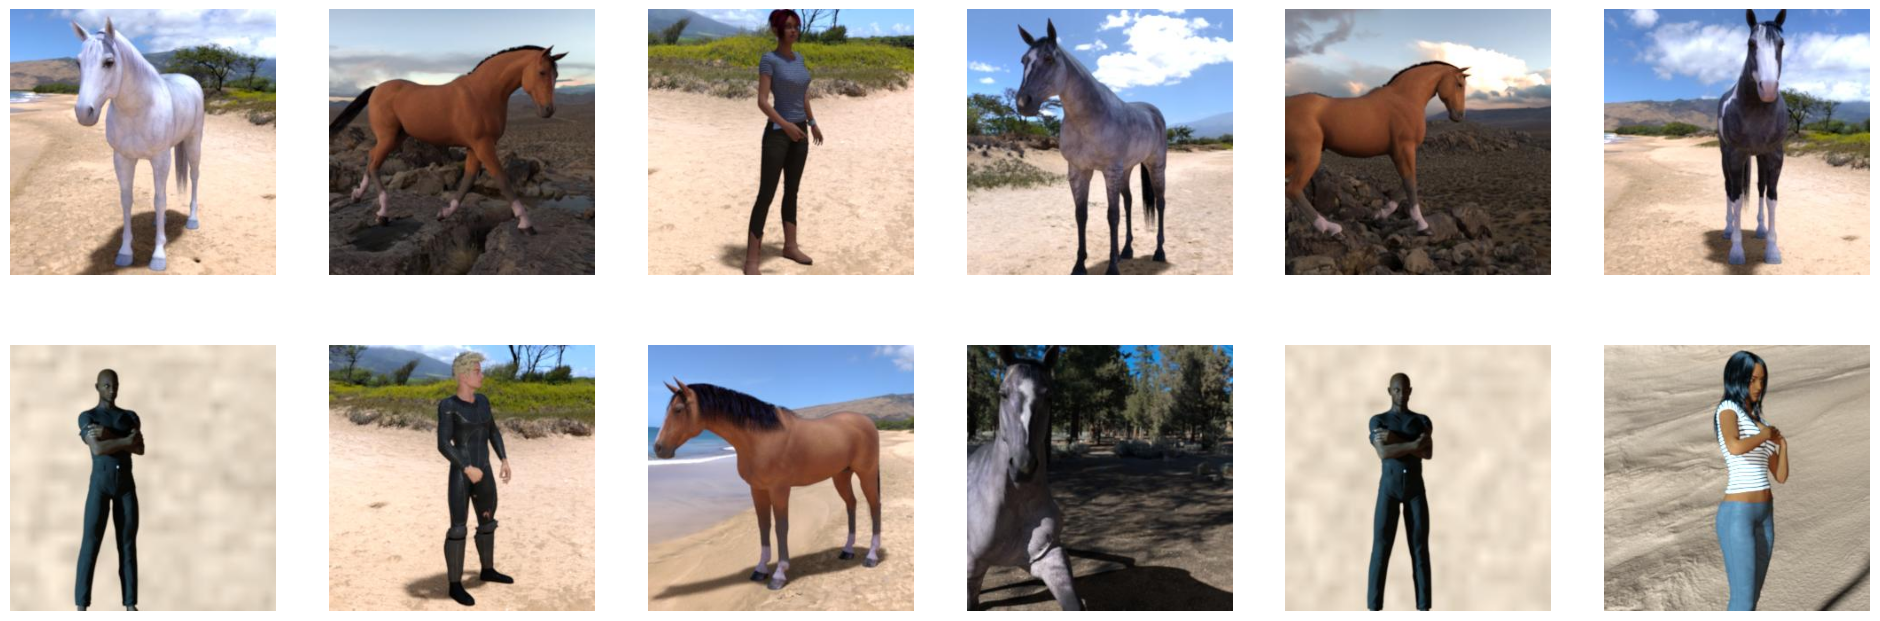

In [13]:
nrows = 2
ncols = 6
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4) # 16x8

next_batch = train_generator.next()
for i in range(0, nrows*ncols):
  ax = plt.subplot(nrows, ncols, i+1)
  ax.axis('Off')
  plt.imshow(next_batch[0][i])

plt.show()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [15]:
def get_model():
  model = Sequential()
  # 1st layer CNN
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(300,300,3)))
  model.add(MaxPool2D(pool_size=2))

  # 2nd layer CNN
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=2))

  # 3rd layer CNN
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=2))

  # flatten layers and FCN
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  return model

In [16]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 128)       0

In [17]:
model = get_model()

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
adamax = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
33/33 [==============================] - 20s 165ms/step - loss: 0.6783 - accuracy: 0.6339 - val_loss: 0.8209 - val_accuracy: 0.5000
Epoch 2/5
33/33 [==============================] - 4s 129ms/step - loss: 0.4472 - accuracy: 0.8179 - val_loss: 0.5032 - val_accuracy: 0.7617
Epoch 3/5
33/33 [==============================] - 5s 141ms/step - loss: 0.2241 - accuracy: 0.9455 - val_loss: 0.4995 - val_accuracy: 0.8242
Epoch 4/5
33/33 [==============================] - 4s 126ms/step - loss: 0.1662 - accuracy: 0.9503 - val_loss: 1.1117 - val_accuracy: 0.7188
Epoch 5/5
33/33 [==============================] - 5s 145ms/step - loss: 0.0899 - accuracy: 0.9796 - val_loss: 1.5779 - val_accuracy: 0.7031


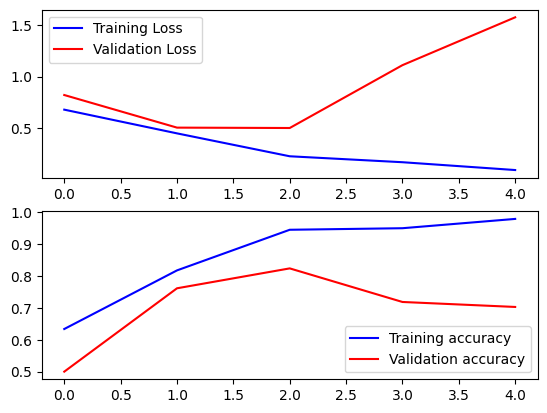

In [18]:
# plot loss and accuracy curve
fix, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend(loc='best')

In [19]:
model.save('horse-or-human.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from tensorflow.keras.models import load_model
model_load = load_model('horse-or-human.h5')

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/horse-or-human/test/humans/humans_111.jpg', target_size=image_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

# predict
prediction = model_load.predict(img)
print(prediction)

TH = 0.5
predicted_class = int(prediction[0][0]>TH)

class_indices = train_generator.class_indices
labels={v:k for k,v in class_indices.items()}
labels[predicted_class]

1/1 [==============================] - 0s 320ms/step
[[0.99999285]]


'humans'